# Helpfulness Prediction
## Data Science and Big Data Analytics Project

---

### Authors: 
- **Andrea Alberti** ([GitHub](https://github.com/AndreaAlberti07))
- **Davide Ligari** ([GitHub](https://github.com/DavideLigari01))
- **Cristian Andreoli** ([GitHub](https://github.com/CristianAndreoli94))

### Date: September 2023

---

## Data: 
The chosen dataset is [Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews).


## Goal:
Build a model able to predict the helpfulness of a review based on its content. 

---

In [1]:
import pymongo as pm
import pyspark as ps
import pandas as pd
import numpy as np
import gensim
import sklearn as sk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Data Loading

In [2]:
client = pm.MongoClient('mongodb://localhost:27017/')
spark_db = client['spark_db']
books_ratings = spark_db['books_rating']

### 2. Data Reshaping

In [3]:
pipeline_remove = {'$match':{
                        'review/score':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
    
                }

smoothing_param = 1

pipeline_project = {'$project':{
                            'review/text':1,
                            'helpfulness_score':{'$divide':[
                                                        {'$sum':['$N_helpful', smoothing_param]},
                                                        {'$sum': ['$Tot_votes', smoothing_param*2]}
                                                             ]
                                                 },
                            '_id':0,
                            }
                    }

mongo_dataset = books_ratings.aggregate([pipeline_remove, pipeline_project])
df_dataset = pd.DataFrame(list(mongo_dataset))
arr_dataset = np.array(df_dataset)

X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(arr_dataset[:,0], arr_dataset[:,1], test_size=0.2, random_state=42)

### 3. Features Extraction

In [4]:
stop_words = set(stopwords.words('english'))

def preprocess(doc):
    tokens = gensim.utils.simple_preprocess(doc)
    return [token for token in tokens if token not in stop_words]

X_train_w2v = [preprocess(doc) for doc in X_train]

In [5]:
model = gensim.models.Word2Vec(X_train_w2v, vector_size=30, window=5, min_count=2)

def get_embedding(doc):
    embeddings = []
    words = preprocess(doc)
    for word in words:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train_embedding = [get_embedding(doc) for doc in X_train]
X_test_embedding = [get_embedding(doc) for doc in X_test]

### 4. Model Training

In [6]:
rand_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rand_forest.fit(X_train_embedding, Y_train)

RandomForestRegressor(random_state=42)

In [7]:
Y_pred_smoothing = rand_forest.predict(X_test_embedding)

In [8]:
def rmse(Y_test, Y_pred):
    return np.sqrt(sk.metrics.mean_squared_error(Y_test, Y_pred))

rmse_smoothing = rmse(Y_test, Y_pred_smoothing)
print('RMSE with smoothing: ', rmse_smoothing)

# Choose a dynamic threshold to determine whether a review is helpful or not

RMSE with smoothing:  0.1558607170520689


### 5. Model Evaluation

In [9]:
# Other approach: change the helpfulness before, and just fit a binary classification model.

# Other: use y as features and x as target, and fit a regression model.

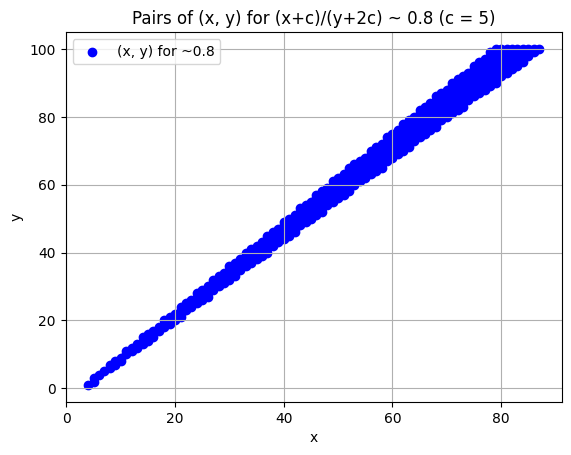

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def equation(c, x, y):
    return (x + c) / (y + 2 * c)

def find_xy_pairs(c, target_ratio, max_value=100):
    valid_pairs = []

    for x in range(1, max_value + 1):
        for y in range(1, max_value + 1):
            if (
                equation(c, x, y) >= target_ratio * 0.95
                and equation(c, x, y) <= target_ratio * 1.05
            ):
                valid_pairs.append((x, y))

    return valid_pairs

c = 5  # Replace with your desired constant value
target_ratio = 0.8  # Replace with your desired target ratio
max_value = 100  # You can adjust this maximum value as needed

valid_pairs = find_xy_pairs(c, target_ratio, max_value)

x_values = [x for x, _ in valid_pairs]
y_values = [y for _, y in valid_pairs]

plt.scatter(x_values, y_values, label=f"(x, y) for ~{target_ratio}", color='blue')
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Pairs of (x, y) for (x+c)/(y+2c) ~ {target_ratio} (c = {c})")
plt.grid(True)
plt.legend()
plt.show()

